In [53]:
# -*- coding: utf-8 -*-
"""
# @file name  : alexnet_inference.py
# @author     : TingsongYu https://github.com/TingsongYu
# @date       : 2020-02-13
# @brief      : inference demo
"""

import os
os.environ['NLS_LANG'] = 'SIMPLIFIED CHINESE_CHINA.UTF8'
import time
import json
import torch.nn as nn
import torch
import torchvision.transforms as transforms
from PIL import Image
from matplotlib import pyplot as plt
import torchvision.models as models
#BASE_DIR = os.path.dirname(os.path.abspath(__file__))
BASE_DIR = os.getcwd()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [54]:
BASE_DIR

'/home/leon/work/myHub/papers/AlexNet/A_alexnet/src'

In [55]:
def img_transform(img_rgb, transform=None):
    """
    将数据转换为模型读取的形式
    :param img_rgb: PIL Image
    :param transform: torchvision.transform
    :return: tensor
    """

    if transform is None:
        raise ValueError("找不到transform！必须有transform对img进行处理")

    img_t = transform(img_rgb)
    return img_t


def load_class_names(p_clsnames, p_clsnames_cn):
    """
    加载标签名
    :param p_clsnames:
    :param p_clsnames_cn:
    :return:
    """
    with open(p_clsnames, "r") as f:
        class_names = json.load(f)
    with open(p_clsnames_cn, encoding='UTF-8') as f:  # 设置文件对象
        class_names_cn = f.readlines()
    return class_names, class_names_cn


def get_model(path_state_dict, vis_model=False):
    """
    创建模型，加载参数
    :param path_state_dict:
    :return:
    """
    model = models.alexnet()
    pretrained_state_dict = torch.load(path_state_dict)
    model.load_state_dict(pretrained_state_dict)
    model.eval()

    if vis_model:
        #pip install torchsummary
        from torchsummary import summary
        summary(model, input_size=(3, 224, 224), device="cpu")

    model.to(device)
    return model


def process_img(path_img):

    # hard code
    norm_mean = [0.485, 0.456, 0.406]
    norm_std = [0.229, 0.224, 0.225]
    inference_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(norm_mean, norm_std),
    ])

    # path --> img
    img_rgb = Image.open(path_img).convert('RGB')

    # img --> tensor
    img_tensor = img_transform(img_rgb, inference_transform)
    img_tensor.unsqueeze_(0)        # chw --> bchw
    img_tensor = img_tensor.to(device)

    return img_tensor, img_rgb

In [56]:
# config
path_state_dict = os.path.join(BASE_DIR, "..", "data", "alexnet-owt-4df8aa71.pth")
# path_img = os.path.join(BASE_DIR, "..", "data", "Golden Retriever from baidu.jpg")
path_img = os.path.join(BASE_DIR, "..", "data", "tiger cat.jpg")
path_classnames = os.path.join(BASE_DIR, "..", "data", "imagenet1000.json")
path_classnames_cn = os.path.join(BASE_DIR, "..", "data", "imagenet_classnames.txt")

In [57]:
print(path_state_dict)

/home/leon/work/myHub/papers/AlexNet/A_alexnet/src/../data/alexnet-owt-4df8aa71.pth


In [58]:
# load class names
cls_n, cls_n_cn = load_class_names(path_classnames, path_classnames_cn)

In [59]:
print(len(cls_n_cn))

1000


In [60]:
# 1/5 load img
img_tensor, img_rgb = process_img(path_img)

In [61]:
# 2/5 load model
alexnet_model = get_model(path_state_dict, True)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 55, 55]          23,296
              ReLU-2           [-1, 64, 55, 55]               0
         MaxPool2d-3           [-1, 64, 27, 27]               0
            Conv2d-4          [-1, 192, 27, 27]         307,392
              ReLU-5          [-1, 192, 27, 27]               0
         MaxPool2d-6          [-1, 192, 13, 13]               0
            Conv2d-7          [-1, 384, 13, 13]         663,936
              ReLU-8          [-1, 384, 13, 13]               0
            Conv2d-9          [-1, 256, 13, 13]         884,992
             ReLU-10          [-1, 256, 13, 13]               0
           Conv2d-11          [-1, 256, 13, 13]         590,080
             ReLU-12          [-1, 256, 13, 13]               0
        MaxPool2d-13            [-1, 256, 6, 6]               0
AdaptiveAvgPool2d-14            [-1, 25

In [62]:
# 3/5 inference  tensor --> vector
with torch.no_grad():
    time_tic = time.time()
    outputs = alexnet_model(img_tensor)
    time_toc = time.time()

In [63]:
# 4/5 index to class names
_, pred_int = torch.max(outputs.data, 1)
_, top5_idx = torch.topk(outputs.data, 5, dim=1)
pred_idx = int(pred_int.cpu().numpy())
pred_str, pred_cn = cls_n[pred_idx], cls_n_cn[pred_idx]
print("img: {} is: {}\n{}".format(os.path.basename(path_img), pred_str, pred_cn))
print("time consuming:{:.2f}s".format(time_toc - time_tic))

img: tiger cat.jpg is: tabby, tabby cat
281 n02123045 猫, tabby, tabby cat

time consuming:0.00s


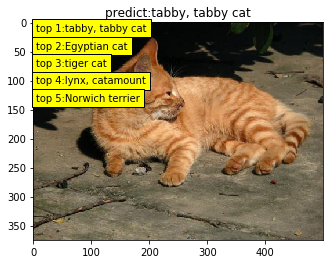

In [64]:
# 5/5 visualization
plt.imshow(img_rgb)
plt.title("predict:{}".format(pred_str))
top5_num = top5_idx.cpu().numpy().squeeze()
text_str = [cls_n[t] for t in top5_num]
for idx in range(len(top5_num)):
    plt.text(5, 15+idx*30, "top {}:{}".format(idx+1, text_str[idx]), bbox=dict(fc='yellow'))
plt.savefig("tom.jpg")
plt.show()